In [125]:
import time
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_predict

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [128]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print ('Finished training in %2.2f seconds \n' % ((te - ts)))
        return result
    return timed

def summary( clf, X_test, y_test):
    print('        Accuracy Score: %.3f' % clf.score(X_test, y_test))
    print('      Model Best Score: %.3f' % clf.best_score_)
    print('   Best Parameters Set: %s\n' % clf.best_params_)
    print('-------- Best Estimator -------- \n%s' % clf.best_estimator_)

def model_metrics(clf, X_test, y_test, cv=5, target_names=None):
    y_pred = cross_val_predict(clf, X_test, y_test, cv=cv)
    cmatrix = confusion_matrix(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred)
    pre_score = precision_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    score = f1_score(y_test, y_pred, average='macro')
    
    report = classification_report(y_test, y_pred, target_names=target_names)
    
    metrics = {'score': score, 
               'roc_score': roc_score, 
               'pre_score': pre_score, 
               'rec_score': rec_score,
               'confusion_matrix': cmatrix,
               'report':report,
               'y_pred': y_pred}
    return metrics

def plot_roc(clf,X_test,y_test):
    y_score = clf.predict_proba(X_test)
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [12]:
responses = pd.read_csv("data/responses.csv",sep="|")

In [13]:
responses.head()

,uuid,top_3pct_time,speeding,navigation_rating,frame_score,straight_line,no_pick_ups,outlier_sales,not_in_database,num_open_ends,class_issue,disqualified,issue_text
0,00cqa4aqhzc53ckg,0.0,0.0,0.0,0.00,0.5,0.0,99.0,0.0,4,0,1,none I loved how it was well stocked and reall...
1,0166jeybemr0fnbs,0.0,0.0,0.0,2.00,0.0,0.0,0.0,0.0,4,0,1,none how well it was organized and the way the...
2,016ba52pk5vz6sph,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,4,0,0,none right on top
3,01jfgcn70kfq0hbg,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,4,0,0,no issues arrangement because of the color
4,02c66p2t3zpx5t3t,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,4,0,0,"none logical, orderly, colorized little chal..."


In [71]:
X = responses[['top_3pct_time', 'speeding', 'navigation_rating', 'frame_score',
               'straight_line', 'no_pick_ups', 'outlier_sales', 'not_in_database', 
               'num_open_ends', 'class_issue']]

y = responses['disqualified'].as_matrix()

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,  test_size=0.2)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model KNeighbors

In [73]:
n_start = 2
n_end = 7
p_start = 1
p_end = 3

params_knn = {'n_neighbors': np.arange(n_start,n_end,1),
              'p': np.arange(p_start,p_end,1)}

In [74]:
knn_clf = KNeighborsClassifier()

f1_macro weights the true and false classes equally which helps to account for the class imbalance

In [75]:
gs_clf = GridSearchCV(knn_clf,  params_knn,  n_jobs=-1,  scoring='f1_macro')
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': array([2, 3, 4, 5, 6]), 'p': array([1, 2])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [35]:
summary(gs_clf, X_test, y_test)

        Accuracy Score: 0.894
Cross Validation Score: 0.878
   Best Parameters Set: {'n_neighbors': 5, 'p': 2}

-------- Best Estimator -------- 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


In [130]:
metrics_knn = model_metrics(gs_clf, X_test, y_test, cv=5,
                            target_names=["True Disqualified","False Disqualified"])

In [39]:
print('       F1 Score: {}'.format(metrics_knn['score']))
print('   Recall Score: {}'.format(metrics_knn['rec_score']))
print('Precision Score: {}'.format(metrics_knn['pre_score']))
print('  ROC AUC Score: {}'.format(metrics_knn['roc_score']))

       F1 Score: 0.8683925302986297
   Recall Score: 0.6931677018633541
Precision Score: 0.8378378378378378
  ROC AUC Score: 0.8398691033564469


In [132]:
print(metrics_knn['report'])

                    precision    recall  f1-score   support

 True Disqualified       0.97      0.99      0.98      8042
False Disqualified       0.85      0.72      0.78       805

       avg / total       0.96      0.96      0.96      8847



### ROC Analysis - Stratified KFold Classification - KNeighbors

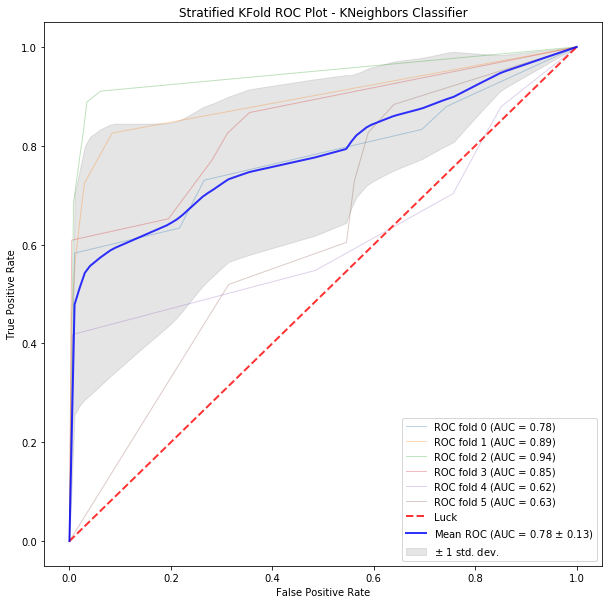

In [100]:
knn_clf = KNeighborsClassifier(n_neighbors=5, p=2)
cv = StratifiedKFold(n_splits=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
X_ = X.as_matrix()
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X_, y):
    probas_ = knn_clf.fit(X_[train], y[train]).predict_proba(X_[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stratified KFold ROC Plot - KNeighbors Classifier')
plt.legend(loc="lower right")
plt.show()

### Model Random Forest

In [112]:
n_start = 5
n_end = 21
params_rf = {'n_estimators': np.arange(n_start, n_end), 
             'class_weight':(None, 'balanced'),
             'max_features':(None, 'auto', 'log2'),
             'criterion':('gini', 'entropy')}

In [113]:
rf_clf = RandomForestClassifier()

In [114]:
gs_rf = GridSearchCV(rf_clf,  params_rf,  n_jobs=-1,  scoring='f1_macro')
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]), 'class_weight': (None, 'balanced'), 'max_features': (None, 'auto', 'log2'), 'criterion': ('gini', 'entropy')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [115]:
summary(gs_rf, X_test, y_test)

        Accuracy Score: 0.891
Cross Validation Score: 0.883
   Best Parameters Set: {'class_weight': None, 'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 13}

-------- Best Estimator -------- 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [133]:
metrics_rf = model_metrics(gs_rf, X_test, y_test, cv=5,
                            target_names=["True Disqualified","False Disqualified"])

In [134]:
print('       F1 Score: {}'.format(metrics_rf['score']))
print('   Recall Score: {}'.format(metrics_rf['rec_score']))
print('Precision Score: {}'.format(metrics_rf['pre_score']))
print('  ROC AUC Score: {}'.format(metrics_rf['roc_score']))

       F1 Score: 0.8896192294757759
   Recall Score: 0.7515527950310559
Precision Score: 0.8509142053445851
  ROC AUC Score: 0.869185997117617


In [135]:
print(metrics_rf['report'])

                    precision    recall  f1-score   support

 True Disqualified       0.98      0.99      0.98      8042
False Disqualified       0.85      0.75      0.80       805

       avg / total       0.96      0.97      0.96      8847



### ROC Analysis - Stratified KFold Classification - Random Forest

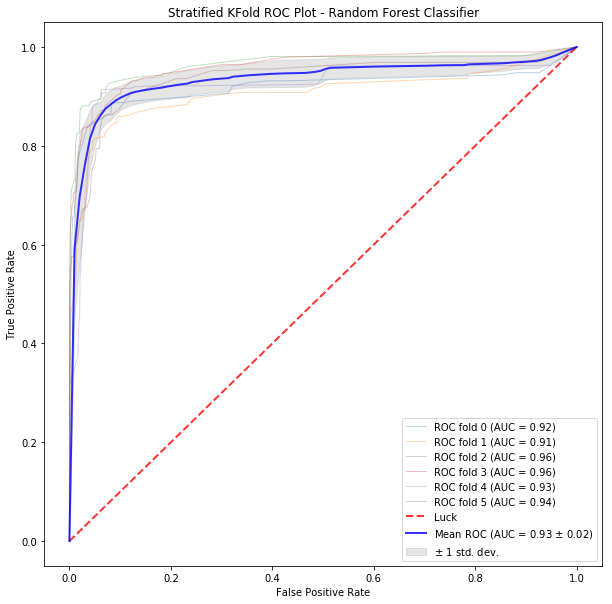

In [122]:
rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

cv = StratifiedKFold(n_splits=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
X_ = X.as_matrix()
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X_, y):
    probas_ = rf_clf.fit(X_[train], y[train]).predict_proba(X_[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stratified KFold ROC Plot - Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

### Model LinearSVC

In [136]:
params_svm = parameters_svm = {'C': ( .01, .1, 1, 10, 20),
               'loss':('hinge', 'squared_hinge'),
               'class_weight': (None, "balanced")}

In [ ]:
svm_clf = LinearSVC()

In [137]:
gs_svm = GridSearchCV(svm_clf,  params_svm,  n_jobs=-1,  scoring='f1_macro')
gs_svm.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': (0.01, 0.1, 1, 10, 20), 'loss': ('hinge', 'squared_hinge'), 'class_weight': (None, 'balanced')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [138]:
summary(gs_svm, X_test, y_test)

        Accuracy Score: 0.857
Cross Validation Score: 0.860
   Best Parameters Set: {'C': 10, 'class_weight': None, 'loss': 'hinge'}

-------- Best Estimator -------- 
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [139]:
metrics_svm = model_metrics(gs_svm, 
                            X_test, y_test, cv=5,
                            target_names=["True Disqualified","False Disqualified"])

In [140]:
print('       F1 Score: {}'.format(metrics_svm['score']))
print('   Recall Score: {}'.format(metrics_svm['rec_score']))
print('Precision Score: {}'.format(metrics_svm['pre_score']))
print('  ROC AUC Score: {}'.format(metrics_svm['roc_score']))

       F1 Score: 0.8690999774361327
   Recall Score: 0.6919254658385093
Precision Score: 0.8426626323751891
  ROC AUC Score: 0.8394966796986628


In [141]:
print(metrics_svm['report'])

                    precision    recall  f1-score   support

 True Disqualified       0.97      0.99      0.98      8042
False Disqualified       0.84      0.69      0.76       805

       avg / total       0.96      0.96      0.96      8847



### ROC Analysis - Stratified KFold Classification -  LinearSVC

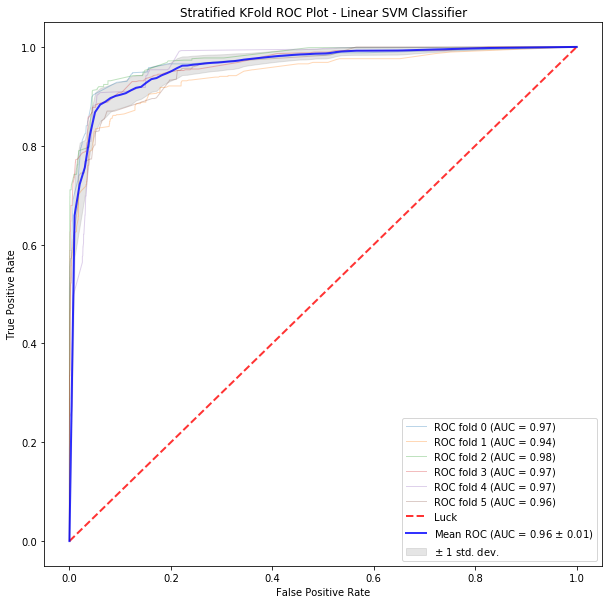

In [159]:
svm_clf = LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

cv = StratifiedKFold(n_splits=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
X_ = X.as_matrix()
plt.figure(figsize=(10,10))
i = 0
for train, test in cv.split(X_, y):
    probas_ = svm_clf.fit(X_[train], y[train]).decision_function(X_[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stratified KFold ROC Plot - Linear SVM Classifier')
plt.legend(loc="lower right")
plt.show()